# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [5]:
!pip install labelme tensorflow 

In [6]:
!pip install opencv-python

In [7]:
!pip install --user albumentations 

### 1.2 Collect Images Using OpenCV

In [8]:
import os
import time
import uuid
import cv2

In [13]:
IMAGES_PATH = os.path.join('data','images')
number_images = 60

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1.0) # 1 second interval

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [15]:
#Incase of Malfunction
cap.release()

### 1.3 Annotate Images with LabelMe

In [4]:
# Use Labelme app directly from cmd

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [9]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [12]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [13]:
images.as_numpy_iterator().next()

b'data\\images\\fc675922-17fc-4637-abb1-e86d4ff266ca.jpg'

In [14]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
images = images.map(load_image)

In [16]:
images.as_numpy_iterator().next()

array([[[123, 122, 120],
        [121, 120, 118],
        [120, 119, 117],
        ...,
        [ 88,  89,  84],
        [ 84,  85,  80],
        [ 79,  80,  75]],

       [[125, 124, 122],
        [123, 122, 120],
        [122, 121, 119],
        ...,
        [ 86,  87,  82],
        [ 81,  82,  77],
        [ 78,  79,  74]],

       [[127, 126, 124],
        [125, 124, 122],
        [124, 123, 121],
        ...,
        [ 79,  78,  74],
        [ 76,  75,  71],
        [ 74,  73,  69]],

       ...,

       [[ 41,  38,  33],
        [ 42,  39,  34],
        [ 42,  39,  34],
        ...,
        [ 26,  26,  28],
        [ 26,  26,  28],
        [ 25,  25,  27]],

       [[ 41,  37,  34],
        [ 41,  37,  34],
        [ 42,  38,  35],
        ...,
        [ 24,  24,  26],
        [ 24,  24,  26],
        [ 23,  23,  25]],

       [[ 41,  37,  34],
        [ 41,  37,  34],
        [ 41,  37,  34],
        ...,
        [ 22,  22,  24],
        [ 21,  21,  23],
        [ 21,  21,  23]]

In [17]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [19]:
plot_images = image_generator.next()

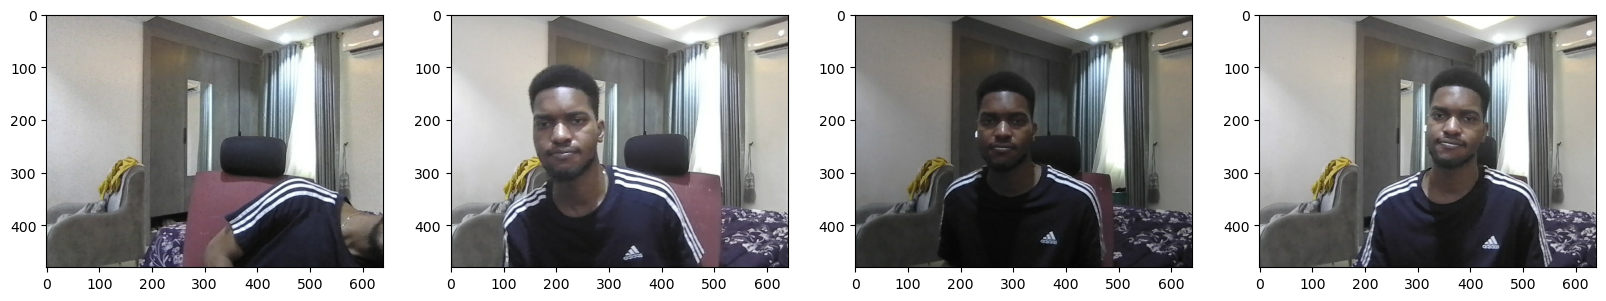

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 SPLITTING DATA INTO TRAIN TEST AND VAL

In [ ]:
180*.7 # 126 to train

In [ ]:
180*.15 # 27 and 27 to test and val

In [21]:
import os
import shutil
import random

# Source directory
source_dir = 'data/images'

# Target directories
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(os.path.join('data', split, 'images'), exist_ok=True)

# Get all images
all_images = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
total_images = len(all_images)

# Shuffle the images randomly
random.shuffle(all_images)

# Define split sizes
train_split = int(0.8 * total_images)
val_split = int(0.1 * total_images)
test_split = total_images - train_split - val_split  # whatever is left

# Split images
train_images = all_images[:train_split]
val_images = all_images[train_split:train_split+val_split]
test_images = all_images[train_split+val_split:]

# Move files accordingly
for img in train_images:
    shutil.copy2(os.path.join(source_dir, img), os.path.join('data', 'train', 'images', img))

for img in val_images:
    shutil.copy2(os.path.join(source_dir, img), os.path.join('data', 'val', 'images', img))

for img in test_images:
    shutil.copy2(os.path.join(source_dir, img), os.path.join('data', 'test', 'images', img))

# Summary
print("Splitting complete ✅")
print(f"Total images: {total_images}")
print(f"Train: {len(train_images)}")
print(f"Val:   {len(val_images)}")
print(f"Test:  {len(test_images)}")


Splitting complete ✅
Total images: 173
Train: 138
Val:   17
Test:  18


### 3.2 Move the Matching Labels

In [22]:

import os
import shutil

# Create target folders for labels
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join('data', split, 'labels'), exist_ok=True)

# Base label source directory
labels_source_dir = 'data/labels'

# Process each split
for split in ['train', 'val', 'test']:
    images_dir = os.path.join('data', split, 'images')
    labels_dir = os.path.join('data', split, 'labels')
    
    image_files = os.listdir(images_dir)

    copied = 0
    missing = 0

    for image_file in image_files:
        # Get base name without extension
        base_name = os.path.splitext(image_file)[0]
        label_file = base_name + '.json'
        src_label_path = os.path.join(labels_source_dir, label_file)
        dest_label_path = os.path.join(labels_dir, label_file)

        if os.path.exists(src_label_path):
            shutil.copy2(src_label_path, dest_label_path)
            copied += 1
        else:
            missing += 1

    print(f"\nSplit: {split}")
    print(f"Labels copied: {copied}")
    if missing > 0:
        print(f"WARNING: {missing} label files missing!")

    


Split: train
Labels copied: 91

Split: val
Labels copied: 10

Split: test
Labels copied: 9


# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [25]:
import albumentations as alb

In [26]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [27]:
img = cv2.imread(os.path.join('data','train', 'images','00adcca8-8c19-45be-b199-35ff91e46ff1.jpg'))

In [28]:
with open(os.path.join('data', 'train', 'labels', '00adcca8-8c19-45be-b199-35ff91e46ff1.json'), 'r') as f:
    label = json.load(f)

In [29]:
label['shapes'][0]['points']

[[53.1521739130435, 143.62318840579712],
 [191.92028985507244, 328.04347826086956]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [30]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [31]:
coords

[53.1521739130435, 143.62318840579712, 191.92028985507244, 328.04347826086956]

In [32]:
coords = list(np.divide(coords, [640,480,640,480])) # normalizing bounding bozes between [0,1]

In [33]:
coords

[0.08305027173913046,
 0.2992149758454107,
 0.29987545289855067,
 0.6834239130434783]

### 4.4 Apply Augmentations and View Results

In [42]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [43]:
augmented['bboxes'][0][2:]

[1.0, 0.7156521987915039]

In [44]:
augmented['bboxes']

[[0.7490660434299045, 0.30582932154337567, 1.0, 0.7156521987915039]]

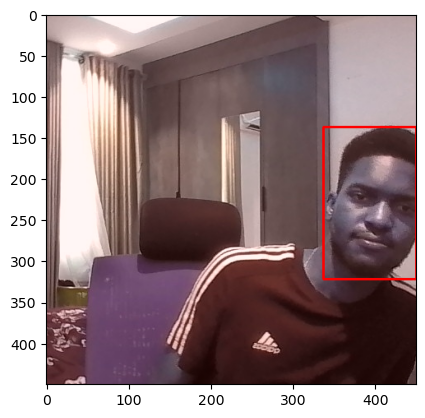

In [45]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [48]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


### 5.2 Load Augmented Images to Tensorflow Dataset

In [77]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [78]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [79]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [80]:
train_images.as_numpy_iterator().next()

array([[[0.7391544 , 0.74699754, 0.74307597],
        [0.7269608 , 0.7348039 , 0.73088235],
        [0.7490196 , 0.75686276, 0.7529412 ],
        ...,
        [0.75490195, 0.75490195, 0.75490195],
        [0.75667894, 0.75667894, 0.75667894],
        [0.7574142 , 0.7574142 , 0.7525123 ]],

       [[0.70226717, 0.70226717, 0.69442403],
        [0.7245098 , 0.7245098 , 0.71666664],
        [0.7244485 , 0.7244485 , 0.71660537],
        ...,
        [0.76911765, 0.76911765, 0.76911765],
        [0.77254903, 0.77254903, 0.77254903],
        [0.7682598 , 0.77316177, 0.77071077]],

       [[0.61807597, 0.615625  , 0.6077819 ],
        [0.6534926 , 0.6534926 , 0.6456495 ],
        [0.6764093 , 0.6764093 , 0.66856617],
        ...,
        [0.77254903, 0.77254903, 0.77254903],
        [0.77947307, 0.77947307, 0.77947307],
        [0.780576  , 0.780576  , 0.77567405]],

       ...,

       [[0.51960784, 0.5117647 , 0.5629289 ],
        [0.4422794 , 0.43443626, 0.48933825],
        [0.61243874, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [83]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [84]:
def wrap_labels(x):
    class_id, bbox = tf.py_function(load_labels, [x], [tf.uint8, tf.float16])
    class_id = tf.squeeze(class_id)   # fix shape: [1] -> []
    class_id.set_shape([])           
    bbox.set_shape([4])              
    return (class_id, bbox)


### 6.2 Load Labels to Tensorflow Dataset

In [85]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(wrap_labels)

In [86]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(wrap_labels)

In [87]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(wrap_labels)

In [88]:
train_labels.as_numpy_iterator().next()

(1, array([0.918 , 0.3103, 1.    , 0.72  ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [89]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8280, 8280, 1080, 1080, 1020, 1020)

### 7.2 Create Final Datasets (Images/Labels)

In [90]:
AUTOTUNE = tf.data.AUTOTUNE

train = tf.data.Dataset.zip((train_images, train_labels)).shuffle(5000).batch(8).prefetch(AUTOTUNE)
test  = tf.data.Dataset.zip((test_images, test_labels)).batch(8).prefetch(AUTOTUNE)
val   = tf.data.Dataset.zip((val_images, val_labels)).batch(8).prefetch(AUTOTUNE)


In [91]:
train.as_numpy_iterator().next()[1]

(array([1, 1, 1, 0, 0, 1, 1, 1], dtype=uint8),
 array([[0.7197, 0.3506, 0.9897, 0.751 ],
        [0.3284, 0.1946, 0.686 , 0.792 ],
        [0.294 , 0.3833, 0.53  , 0.7324],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1519, 0.2178, 0.4963, 0.7925],
        [0.2347, 0.2114, 0.605 , 0.807 ],
        [0.642 , 0.2778, 0.986 , 0.7827]], dtype=float16))

### 7.3 View Images and Annotations

In [92]:
data_samples = train.as_numpy_iterator()

In [93]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


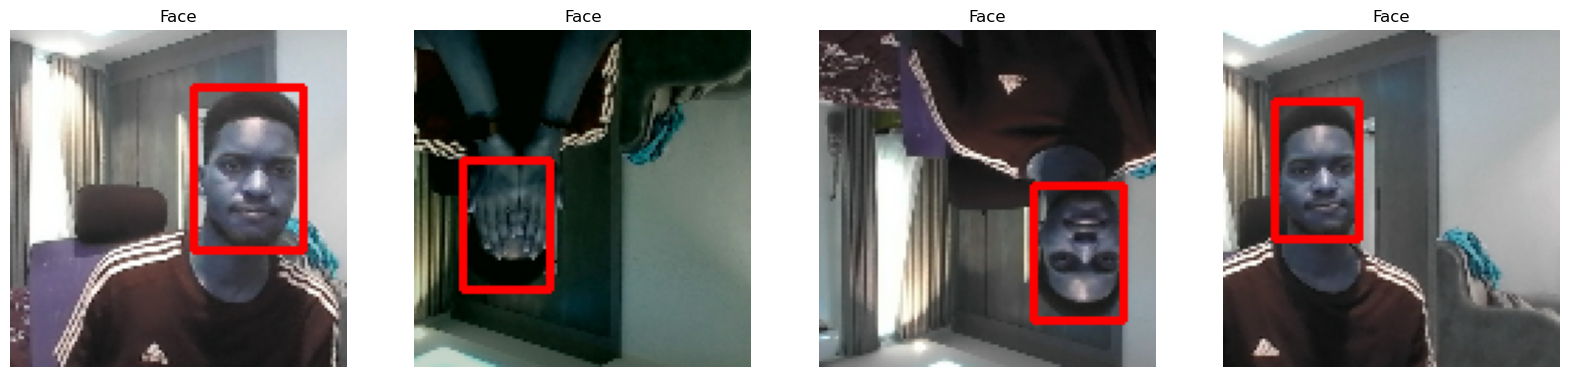

In [94]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = np.clip(res[1][1][idx], 0, 1)  # bbox
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # convert for plt

    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)

    label = "Face" if res[1][0][idx] == 1 else "No Face"
    ax[idx].imshow(sample_image)
    ax[idx].set_title(label)
    ax[idx].axis('off')


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [95]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [96]:
vgg = VGG16(include_top=False)

In [97]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [98]:

def build_model(): 
    input_layer = Input(shape=(120, 120, 3))
    
    # Load VGG16 base
    vgg = VGG16(include_top=False, input_tensor=input_layer)

    # Freeze VGG layers
    for layer in vgg.layers:
        layer.trainable = False

    # Classification head
    f1 = GlobalMaxPooling2D()(vgg.output)
    class1 = Dense(2048, activation='relu')(f1)
    class_output = Dense(1, activation='sigmoid', name='class_output')(class1)

    # Regression head
    f2 = GlobalMaxPooling2D()(vgg.output)
    regress1 = Dense(2048, activation='relu')(f2)
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(regress1)  # use sigmoid if normalized

    model = Model(inputs=input_layer, outputs=[class_output, bbox_output])
    return model


### 8.4 Test out Neural Network

In [99]:
facetracker = build_model()

In [100]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 120, 120, 64)      │           1,792 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 120, 120, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 60, 60, 64)        │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 60, 60, 128)       │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 60, 60, 128)       │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 30, 30, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 30, 30, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 30, 30, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 30, 30, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 15, 15, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 15, 15, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 15, 15, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 15, 15, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 7, 7, 512)         │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv1 (Conv2D)         │ (None, 7, 7, 512)         │       2,359,808 │ block4_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv2 (Conv2D)         │ (None, 7, 7, 512)         │       2,359,808 │ block5_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 2,111,493 (8.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [101]:
X, y = train.as_numpy_iterator().next()

In [102]:
X.shape

(8, 120, 120, 3)

In [103]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


In [104]:
classes, coords

(array([[0.52271295],
        [0.5696629 ],
        [0.52528536],
        [0.5416103 ],
        [0.5505192 ],
        [0.6190821 ],
        [0.46299386],
        [0.6005889 ]], dtype=float32),
 array([[0.6813052 , 0.5302801 , 0.7489127 , 0.33981654],
        [0.70218253, 0.4625386 , 0.6852118 , 0.42221022],
        [0.79803973, 0.55970204, 0.5440518 , 0.36250415],
        [0.73665154, 0.57915235, 0.6424842 , 0.39447835],
        [0.70168334, 0.5117236 , 0.64375216, 0.45151365],
        [0.7020799 , 0.5235226 , 0.68375254, 0.4536338 ],
        [0.7498574 , 0.5461523 , 0.69285953, 0.3820399 ],
        [0.69271374, 0.43869954, 0.6386392 , 0.4642341 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [105]:
# Cosine decay learning rate to smooth early training
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-5
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### 9.2 Create Localization Loss and Classification Loss

In [106]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]
    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [107]:
def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(tf.less(diff, 1.0), tf.float32)
    return tf.reduce_mean(less_than_one * 0.5 * diff ** 2 + (1.0 - less_than_one) * (diff - 0.5))

In [108]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = smooth_l1_loss

### 9.3 Test out Loss Metrics

In [109]:
smooth_l1_loss(y[1], coords).numpy()

0.1372024

In [110]:
classloss(y[0], classes).numpy()

0.7265228

In [111]:
regressloss(y[1], coords).numpy()

0.1372024

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [112]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, optimizer, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.optimizer = optimizer
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = 2.0*batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = 2.0*batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [113]:
model = FaceTracker(facetracker)

In [114]:
# Define focal loss to stabilize classification
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return loss

# Replace your existing classloss
classloss = focal_loss()

In [115]:
model.compile(optimizer, classloss, regressloss)

### 10.2 Train

In [116]:
logdir='logs'

In [117]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.EarlyStopping(monitor='val_total_loss', mode='min', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor='val_total_loss', mode='min', save_best_only=True)
]



In [118]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=callbacks)

Epoch 1/30
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - class_loss: 0.0452 - regress_loss: 0.0118 - total_loss: 0.0463

C:\Users\iamth\anaconda3\Lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1035/1035 ━━━━━━━━━━━━━━━━━━━━ 375s 351ms/step - class_loss: 0.0452 - regress_loss: 0.0118 - total_loss: 0.0463 - val_class_loss: 0.0536 - val_regress_loss: 0.0188 - val_total_loss: 0.0644
Epoch 2/30
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 372s 352ms/step - class_loss: 0.0415 - regress_loss: 0.0043 - total_loss: 0.0295 - val_class_loss: 0.0472 - val_regress_loss: 0.0070 - val_total_loss: 0.0375
Epoch 3/30
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 374s 354ms/step - class_loss: 0.0413 - regress_loss: 0.0023 - total_loss: 0.0253 - val_class_loss: 0.0477 - val_regress_loss: 0.0123 - val_total_loss: 0.0484
Epoch 4/30
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 375s 355ms/step - class_loss: 0.0414 - regress_loss: 0.0032 - total_loss: 0.0271 - val_class_loss: 0.0511 - val_regress_loss: 0.0338 - val_total_loss: 0.0932
Epoch 5/30
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 376s 356ms/step - class_loss: 0.0413 - regress_loss: 0.0022 - total_loss: 0.0250 - val_class_loss: 0.0500 - val_regress_loss: 0.0048 - val_total_loss: 0.0345
Epoch 6/30


### 10.3 Plot Performance

In [119]:
hist.history

{'class_loss': [0.0492139533162117,
  0.03884173557162285,
  0.03569667786359787,
  0.032403260469436646,
  0.03807162493467331,
  0.05108439549803734,
  0.0322224386036396,
  0.033971644937992096,
  0.041869986802339554,
  0.03915264457464218,
  0.037891242653131485,
  0.0418584980070591,
  0.044893115758895874,
  0.041839778423309326,
  0.03819918632507324,
  0.044941309839487076,
  0.04529958218336105],
 'regress_loss': [0.009930183179676533,
  0.0013821853790432215,
  0.0015309636946767569,
  0.0012944764457643032,
  0.0012108837254345417,
  0.00022135386825539172,
  0.0008989798952825367,
  0.0004964402760379016,
  0.0005085436860099435,
  0.00037842171150259674,
  0.00011888932931469753,
  0.0002934578515123576,
  8.690872346051037e-05,
  0.0005068347090855241,
  0.0022294241935014725,
  0.002580871805548668,
  0.0006692985189147294],
 'total_loss': [0.044467344880104065,
  0.02218523807823658,
  0.020910266786813736,
  0.018790584057569504,
  0.021457578986883163,
  0.0259849056

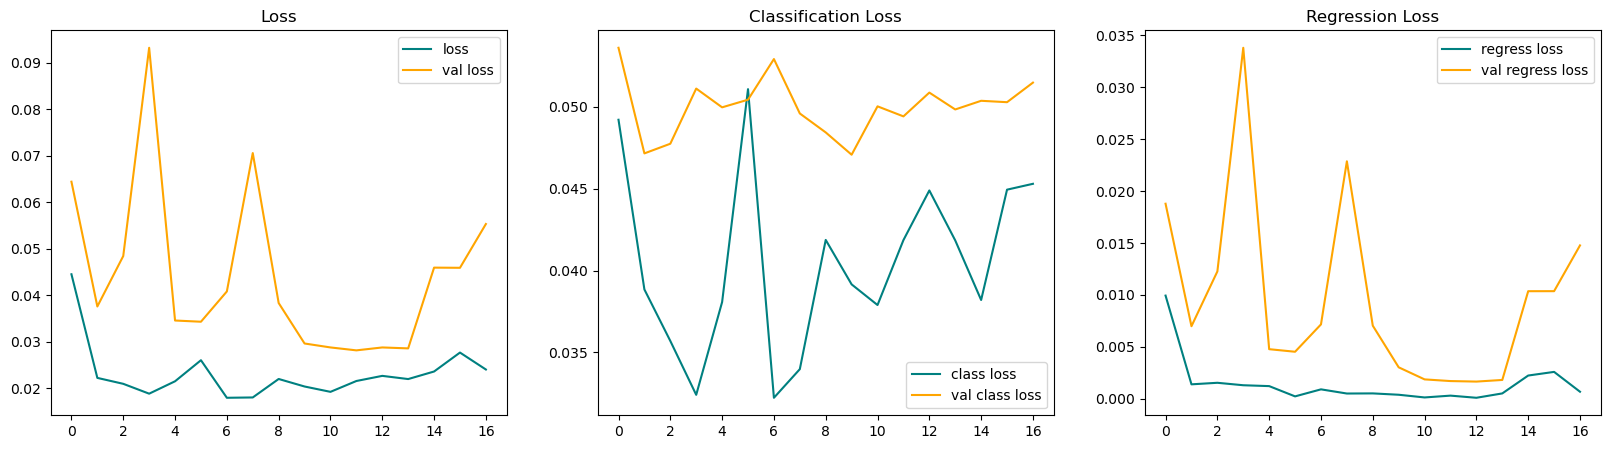

In [120]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [127]:
test_data = test.as_numpy_iterator()

In [128]:
test_sample = test_data.next()

In [129]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


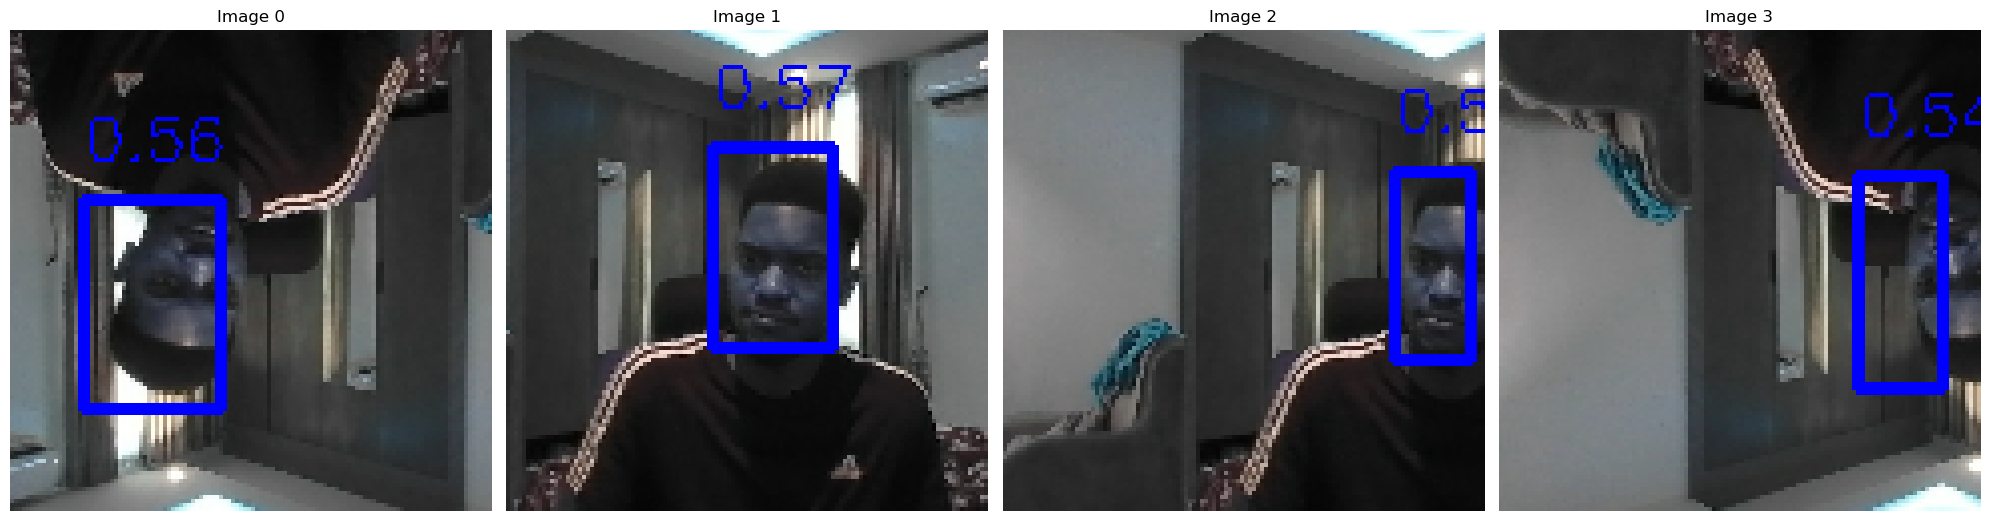

In [130]:

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    # Make a writable copy of the image
    sample_image = test_sample[0][idx].copy()

    # Get predicted bounding box and class confidence
    sample_coords = yhat[1][idx]  # [x1, y1, x2, y2] in normalized format
    confidence = yhat[0][idx]     # scalar value

    if confidence > 0.1:  # Loosen threshold for visibility
        # Convert from normalized [0, 1] to pixel coordinates
        x1, y1 = np.multiply(sample_coords[:2], [120, 120]).astype(int)
        x2, y2 = np.multiply(sample_coords[2:], [120, 120]).astype(int)

        # Draw bounding box on BGR image
        cv2.rectangle(sample_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Optional: add confidence score label
        label = f"{confidence[0]:.2f}" if isinstance(confidence, (np.ndarray, list)) else f"{confidence:.2f}"
        cv2.putText(sample_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (255, 0, 0), 1)

    # Now convert to RGB *after* drawing
    sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    # Plot the image
    ax[idx].imshow(sample_image_rgb)
    ax[idx].axis('off')
    ax[idx].set_title(f"Image {idx}")

plt.tight_layout()
plt.show()


### 11.2 Save the Model

In [131]:
from tensorflow.keras.models import load_model

In [132]:
facetracker.save('webcam_face_detector.keras')

In [133]:
facetracker = load_model('webcam_face_detection.keras')

### 11.3 Real Time Detection

In [135]:
cap.release()